In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree

In [78]:
data=pd.read_csv('Customer-Churn.csv')

In [79]:
data.TotalCharges = pd.to_numeric(data.TotalCharges,errors='coerce')

In [80]:
data.TotalCharges

0         29.85
1       1889.50
2        108.15
3       1840.75
4        151.65
         ...   
7038    1990.50
7039    7362.90
7040     346.45
7041     306.60
7042    6844.50
Name: TotalCharges, Length: 7043, dtype: float64

In [81]:
data=data.dropna()

In [82]:
X = data.drop(['Churn'], axis = 1)
y = data['Churn']

In [83]:
num=X.select_dtypes(include=np.number)
cat=X.select_dtypes(include=np.object)

In [84]:
num

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
0,0,1,29.85,29.85
1,0,34,56.95,1889.50
2,0,2,53.85,108.15
3,0,45,42.30,1840.75
4,0,2,70.70,151.65
...,...,...,...,...
7038,0,24,84.80,1990.50
7039,0,72,103.20,7362.90
7040,0,11,29.60,346.45
7041,1,4,74.40,306.60


In [85]:
cat=pd.get_dummies(cat)

In [86]:
X=pd.concat([cat,num],axis=1)

In [88]:
X.shape

(7032, 33)

In [89]:
y.shape

(7032,)

In [76]:
X.isna().sum()

gender_Female                           0
gender_Male                             0
Partner_No                              0
Partner_Yes                             0
Dependents_No                           0
Dependents_Yes                          0
PhoneService_No                         0
PhoneService_Yes                        0
OnlineSecurity_No                       0
OnlineSecurity_No internet service      0
OnlineSecurity_Yes                      0
OnlineBackup_No                         0
OnlineBackup_No internet service        0
OnlineBackup_Yes                        0
DeviceProtection_No                     0
DeviceProtection_No internet service    0
DeviceProtection_Yes                    0
TechSupport_No                          0
TechSupport_No internet service         0
TechSupport_Yes                         0
StreamingTV_No                          0
StreamingTV_No internet service         0
StreamingTV_Yes                         0
StreamingMovies_No                

In [124]:
def classification_model(X,y,tomek,balancer,scaler,neighbors):
    import matplotlib.pyplot as plt
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import confusion_matrix,plot_confusion_matrix, cohen_kappa_score, accuracy_score, classification_report, fbeta_score, make_scorer
    from sklearn.preprocessing import PowerTransformer
    from sklearn.model_selection import GridSearchCV
    from sklearn.svm import LinearSVC
    from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
    from sklearn import svm
    from imblearn.under_sampling import TomekLinks, RandomUnderSampler
    from imblearn.over_sampling import RandomOverSampler, SMOTE
    from sklearn.metrics import fbeta_score, make_scorer
    from sklearn.linear_model import LogisticRegression
    from sklearn.tree import DecisionTreeClassifier

    
    tl = TomekLinks('majority')
    rus = RandomUnderSampler()
    Ros = RandomOverSampler()
    smote = SMOTE()
    ftwo_scorer = make_scorer(cohen_kappa_score)
    
#Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)
    
#Scaler
    if scaler=="StandardScaler":
        scaler_x = StandardScaler().fit(X_train)
        X_train_scaled = pd.DataFrame(scaler_x.transform(X_train),columns=X.columns)
        X_test_scaled = pd.DataFrame(scaler_x.transform(X_test),columns=X.columns)
    elif scaler=="MinMax":
        scaler_x = MinMaxScaler().fit(X_train)
        X_train_scaled = pd.DataFrame(scaler_x.transform(X_train),columns=X.columns)
        X_test_scaled = pd.DataFrame(scaler_x.transform(X_test),columns=X.columns)
    elif scaler=="Normalizer":
        scaler_x = Normalizer().fit(X_train)
        X_train_scaled = pd.DataFrame(scaler_x.transform(X_train),columns=X.columns)
        X_test_scaled = pd.DataFrame(scaler_x.transform(X_test),columns=X.columns)
    elif scaler=="power":
        pt = PowerTransformer()
        powertrain=pt.fit(X_train)
        powertrainl=(pt.lambdas_)
        powertrain=pt.transform(X_train)
        X_train_scaled=pd.DataFrame(powertrain,columns=X_train.columns)
        powertest=pt.fit(X_test)
        powerltest=(pt.lambdas_)
        powertest=pt.transform(X_test)
        X_test_scaled=pd.DataFrame(powertest,columns=X_test.columns)
    elif scaler=="None":
        X_train_scaled=X_train
        X_test_scaled=X_test
        
#sample balance
    if tomek=="tomek applied":
        X_train_scaled_tom, y_train_scaled_tom=tl.fit_sample(X_train_scaled, y_train)
    elif tomek=="tomek not applied":
        X_train_scaled_tom,y_train_scaled_tom=X_train_scaled,y_train
    
    if balancer=="smote sample":
        X_train_scaled_bal, y_train_scaled_bal = smote.fit_sample(X_train_scaled_tom, y_train_scaled_tom)
    elif balancer=="over sample":
        X_train_scaled_bal, y_train_scaled_bal = Ros.fit_sample(X_train_scaled_tom, y_train_scaled_tom)
    elif balancer=="under sample":
        X_train_scaled_bal, y_train_scaled_bal = rus.fit_sample(X_train_scaled_tom, y_train_scaled_tom)
    elif balancer=="unbalanced":
        X_train_scaled_bal,y_train_scaled_bal=X_train_scaled_tom,y_train_scaled_tom
        
#models
    #CLass
    log_ = LogisticRegression(random_state=0, solver='lbfgs', multi_class='ovr', class_weight = {'Yes': 0.2, 'No': 0.8}, C= 1)
    log_classification = log_.fit(X_train_scaled_bal, y_train_scaled_bal)
    log_predictions = log_classification.predict(X_test_scaled)
    #grid = GridSearchCV(LogisticRegression(), param_grid={'solver': ['lbfgs', 'saga'], 'C': [1,0.1,0.001], 'class_weight':[{'Yes': 0.2, 'No': 0.8},'balanced',None,{'Yes': 0.1, 'No': 1.6}]},scoring=ftwo_scorer, n_jobs =2)
    #grid.fit(X_train_scaled_bal, y_train_scaled_bal)
    #print(grid.best_params_,grid.best_score_,grid.best_estimator_)
    

  
    #Forest
    clf = DecisionTreeClassifier()
    clf_classification = clf.fit(X_train_scaled_bal, y_train_scaled_bal)
    clf_predictions = clf.predict(X_test_scaled)
    #gridf = GridSearchCV(RandomForestClassifier(), param_grid={},scoring=ftwo_scorer, n_jobs =2)
    #gridf.fit(X_train_scaled_bal, y_train_scaled_bal)
    #print(gridf.best_params_,gridf.best_score_,gridf.best_estimator_)


    
#printing results
    print("| Logistic Regression Model Results")
    print("With:: - Sample balancing: ", tomek,",", balancer,", - Scaler: ", scaler)
    print("The accuracy of the model on test set is: %4.2f " % accuracy_score(y_test, log_predictions))
    print("The Kappa of your model is: %4.2f" % (cohen_kappa_score(y_test, log_predictions)))
    print(cohen_kappa_score)
    print(confusion_matrix(y_test, log_predictions))
    plot_confusion_matrix(log_classification, X_test_scaled, y_test)  # doctest: +SKIP
    plt.show()

  

    print("| Decision Tree Classifier Results")
    print("With:: - Sample balancing: ", tomek,",", balancer,", - Scaler: ", scaler)
    print("The accuracy of the model on test set is: %4.2f " % accuracy_score(y_test, clf_predictions))
    print("The Kappa of your model is: %4.2f" % (cohen_kappa_score(y_test, clf_predictions)))
    print(confusion_matrix(y_test, clf_predictions))
    plot_confusion_matrix(clf_classification, X_test_scaled, y_test)  # doctest: +SKIP
    plt.show()

    

    
    return X_train_scaled_bal,y_train_scaled_bal

C:\Users\Nickolaus Smith\anaconda3\lib\site-packages\imblearn\utils\_validation.py:635: FutureWarning: Pass sampling_strategy=majority as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.9 "
C:\Users\Nickolaus Smith\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


| Logistic Regression Model Results
With:: - Sample balancing:  tomek not applied , smote sample , - Scaler:  None
The accuracy of the model on test set is: 0.77 
The Kappa of your model is: 0.29
<function cohen_kappa_score at 0x0000010DAF256040>
[[1456   72]
 [ 415  167]]


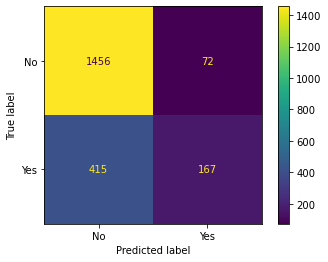

| Random Forest Classifier Results
With:: - Sample balancing:  tomek not applied , smote sample , - Scaler:  None
The accuracy of the model on test set is: 0.71 
The Kappa of your model is: 0.27
[[1234  294]
 [ 313  269]]


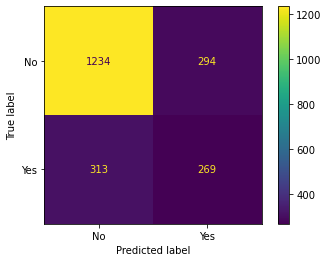

In [123]:
X_train_scaled_bal,y_train_scaled_bal=classification_model(X,y,"tomek not applied","smote sample","None",2)

C:\Users\Nickolaus Smith\anaconda3\lib\site-packages\imblearn\utils\_validation.py:635: FutureWarning: Pass sampling_strategy=majority as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.9 "


| Logistic Regression Model Results
With:: - Sample balancing:  tomek applied , unbalanced , - Scaler:  None
The accuracy of the model on test set is: 0.75 
The Kappa of your model is: 0.15
<function cohen_kappa_score at 0x0000010DAF256040>
[[1500   28]
 [ 507   75]]


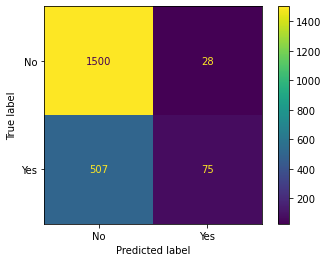

| Decision Tree Classifier Results
With:: - Sample balancing:  tomek applied , unbalanced , - Scaler:  None
The accuracy of the model on test set is: 0.72 
The Kappa of your model is: 0.31
[[1205  323]
 [ 273  309]]


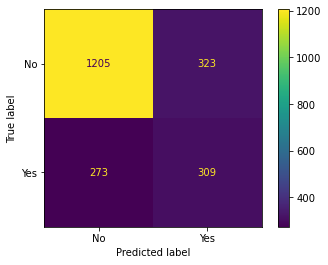

In [135]:
X_train_scaled_bal2,y_train_scaled_bal2=classification_model(X,y,"tomek applied","unbalanced","None",2)

C:\Users\Nickolaus Smith\anaconda3\lib\site-packages\imblearn\utils\_validation.py:635: FutureWarning: Pass sampling_strategy=majority as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.9 "


| Logistic Regression Model Results
With:: - Sample balancing:  tomek not applied , smote sample , - Scaler:  StandardScaler
The accuracy of the model on test set is: 0.79 
The Kappa of your model is: 0.42
<function cohen_kappa_score at 0x0000010DAF256040>
[[1417  111]
 [ 324  258]]


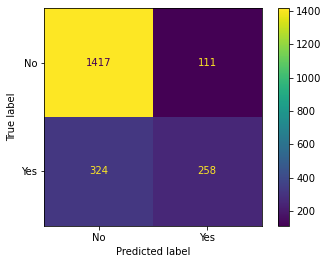

| Random Forest Classifier Results
With:: - Sample balancing:  tomek not applied , smote sample , - Scaler:  StandardScaler
The accuracy of the model on test set is: 0.75 
The Kappa of your model is: 0.40
[[1251  277]
 [ 240  342]]


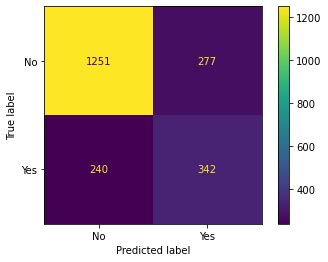

In [111]:
X_train_scaled_bal3,y_train_scaled_bal3=classification_model(X,y,"tomek not applied","smote sample","StandardScaler",2)

C:\Users\Nickolaus Smith\anaconda3\lib\site-packages\imblearn\utils\_validation.py:635: FutureWarning: Pass sampling_strategy=majority as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.9 "


| Logistic Regression Model Results
With:: - Sample balancing:  tomek applied , unbalanced , - Scaler:  StandardScaler
The accuracy of the model on test set is: 0.75 
The Kappa of your model is: 0.16
<function cohen_kappa_score at 0x0000010DAF256040>
[[1499   29]
 [ 499   83]]


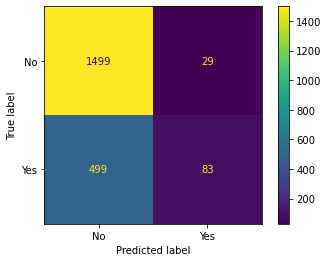

| Decision Tree Classifier Results
With:: - Sample balancing:  tomek applied , unbalanced , - Scaler:  StandardScaler
The accuracy of the model on test set is: 0.71 
The Kappa of your model is: 0.30
[[1172  356]
 [ 260  322]]


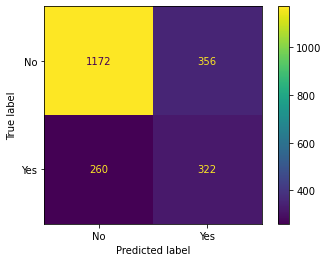

In [127]:
X_train_scaled_bal4,y_train_scaled_bal4=classification_model(X,y,"tomek applied","unbalanced","StandardScaler",2)

In [119]:
import pandas as pd
import numpy as np

from sklearn.datasets import load_boston
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [132]:
model1 = DecisionTreeClassifier()
model2 = LogisticRegression(max_iter=300)


In [133]:
model_pipeline = [model1, model2]
model_names = ['DecisionTreeClassifier', 'LogisticRegression']


def confidence_intervals(model_pipeline, model_names, X_train, y_train, alpha = 0.05, K = 10):
# We set the significance level
#alpha = 0.05
#K = 10
    scores = {}
    i=0
    for model in model_pipeline:
        mean_score = np.mean(cross_val_score(model, X_train, y_train, cv=K))
        if (K < 30):
            # t.ppf(area) gives us the critical value corresponding to the area for the t-student distribution.
            t_critical = abs(t.ppf(1-alpha/2, K-1)) 
            interval = t_critical*(np.std(cross_val_score(model, X_train, y_train, cv=K))/np.sqrt(K))
        else:
            # norm.ppf(area) gives us the critical value corresponding to the area for the normal distribution
            z_critical = abs(norm.ppf(1-alpha/2)) 
            interval = z_critical*(np.std(cross_val_score(model, X_train, y_train, cv=K))/np.sqrt(K))
        scores[model_names[i]] = [mean_score, mean_score - interval, mean_score + interval]
        print("The rmse of the {} model is (CV witk K={}) = {:4.2f} +/- {:4.2f}".format(model_names[i], K, mean_score, interval))
        i = i+1

confidence_intervals(model_pipeline, model_names, X_train_scaled_bal4, y_train_scaled_bal4, 0.05, 5)

The rmse of the DecisionTreeClassifier model is (CV witk K=5) = 0.76 +/- 0.01
The rmse of the LogisticRegression model is (CV witk K=5) = 0.82 +/- 0.01


In [136]:
confidence_intervals(model_pipeline, model_names, X_train_scaled_bal2, y_train_scaled_bal2, 0.05, 5)

The rmse of the DecisionTreeClassifier model is (CV witk K=5) = 0.74 +/- 0.02


C:\Users\Nickolaus Smith\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Nickolaus Smith\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

The rmse of the LogisticRegression model is (CV witk K=5) = 0.82 +/- 0.01
